## **Parte 1:** Importanción de librerías

Importando las librerías necesarias

In [1]:
import tensorflow as tf

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import Conv1D, MaxPool1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [2]:
# Configurar TensorFlow para usar la GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## **Parte 2:** Cargando los datos

In [3]:
df = pd.read_csv("../../BD_procesada/BD_procesada.csv", sep=";")
df.head()

,muestra 1,muestra 2,muestra 3,muestra 4,muestra 5,muestra 6,muestra 7,muestra 8,muestra 9,muestra 10,...,muestra 2492,muestra 2493,muestra 2494,muestra 2495,muestra 2496,muestra 2497,muestra 2498,muestra 2499,muestra 2500,estructura
0,-54,-14,-102,-286,-384,-379,-358,-340,-244,-144,...,45,100,58,31,1,-25,15,0,-4,1
1,-142,-242,-218,-144,-150,-214,-145,33,226,315,...,61,-59,-125,-86,70,162,234,189,151,1
2,2,7,15,27,47,45,-9,-75,-94,-71,...,-108,-81,-86,-27,-24,-11,-2,47,38,0
3,135,-96,-6,-100,10,-68,-138,-335,-373,-199,...,116,111,279,282,333,138,-17,-14,-200,0
4,-68,-91,67,119,83,128,-55,22,-139,-69,...,-18,17,157,255,322,467,188,298,199,0


## **Parte 3:** transformando los datos

Diviendo el conjunto en entranimiento y prueba

In [4]:
X = df.drop(columns=['estructura'], axis=1)
y = df['estructura']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print("Dimensiones X_train: {}".format(X_train.shape))
print("Dimensiones X_test: {}".format(X_test.shape))
print("Dimensiones y_train: {}".format(y_train.shape))
print("Dimensiones y_test: {}".format(y_test.shape))

Dimensiones X_train: (3600, 2500)
Dimensiones X_test: (400, 2500)
Dimensiones y_train: (3600,)
Dimensiones y_test: (400,)


Estandarizar los datos

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Forma X_train_scaled: {}".format(X_train_scaled.shape))
print("Forma X_test_scaled: {}".format(X_test_scaled.shape))

Forma X_train_scaled: (3600, 2500)
Forma X_test_scaled: (400, 2500)


Reshape de los datos para que tengan la forma adecuada para la convolución (número de registros, longitud de los registros, número de características)

In [6]:
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

print("Forma X_train_reshaped: {}".format(X_train_reshaped.shape))
print("Forma X_test_reshaped: {}".format(X_test_reshaped.shape))

Forma X_train_reshaped: (3600, 2500, 1)
Forma X_test_reshaped: (400, 2500, 1)


## **Parte 4:** Modelo

Creación del modelo

In [7]:
modelo = Sequential()

#Estructura del modelo
modelo.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
modelo.add(MaxPool1D(pool_size=8, strides=5))
modelo.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(l2=0.01)))
modelo.add(MaxPool1D(pool_size=8, strides=5))
modelo.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(l2=0.01)))
modelo.add(MaxPool1D(pool_size=8, strides=5))
modelo.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(l2=0.01)))
modelo.add(MaxPool1D(pool_size=8, strides=5))


modelo.add(Flatten())

modelo.add(Dense(128, activation='relu', kernel_regularizer=l2(l2=0.01)))
modelo.add(Dropout(0.5))
modelo.add(Dense(128, activation='relu', kernel_regularizer=l2(l2=0.01)))
modelo.add(Dropout(0.5))
modelo.add(Dense(1, activation='sigmoid'))

#Compilación del modelo
modelo.compile(optimizer=Adam(learning_rate=0.01), loss = 'binary_crossentropy', metrics=["accuracy"])

#Se define un callback para guardar el mejor modelo basado en el val_accuracy
checkpoint_callback = ModelCheckpoint(
    filepath = "modelo_generado/mejor_modelo.keras",
    monitor = "val_accuracy",
    save_best_only = True,
    mode = "max",
    verbose = 1
)

history = modelo.fit(X_train_reshaped, y_train, epochs=200, batch_size=512, validation_split=0.1, callbacks=[checkpoint_callback])


Epoch 1/200
7/7 [==============================] - ETA: 0s - loss: 3.4160 - accuracy: 0.5315
Epoch 1: val_accuracy improved from -inf to 0.66667, saving model to modelo_generado\mejor_modelo.keras
7/7 [==============================] - 3s 134ms/step - loss: 3.4160 - accuracy: 0.5315 - val_loss: 1.5053 - val_accuracy: 0.6667
Epoch 2/200
6/7 [========================>.....] - ETA: 0s - loss: 1.1302 - accuracy: 0.5960
Epoch 2: val_accuracy did not improve from 0.66667
7/7 [==============================] - 0s 57ms/step - loss: 1.1161 - accuracy: 0.6015 - val_loss: 0.8656 - val_accuracy: 0.5722
Epoch 3/200
6/7 [========================>.....] - ETA: 0s - loss: 0.8450 - accuracy: 0.6751
Epoch 3: val_accuracy did not improve from 0.66667
7/7 [==============================] - 0s 55ms/step - loss: 0.8491 - accuracy: 0.6657 - val_loss: 0.8638 - val_accuracy: 0.6250
Epoch 4/200
6/7 [========================>.....] - ETA: 0s - loss: 0.8325 - accuracy: 0.6816
Epoch 4: val_accuracy improved from 0

Registros del entrenamiento

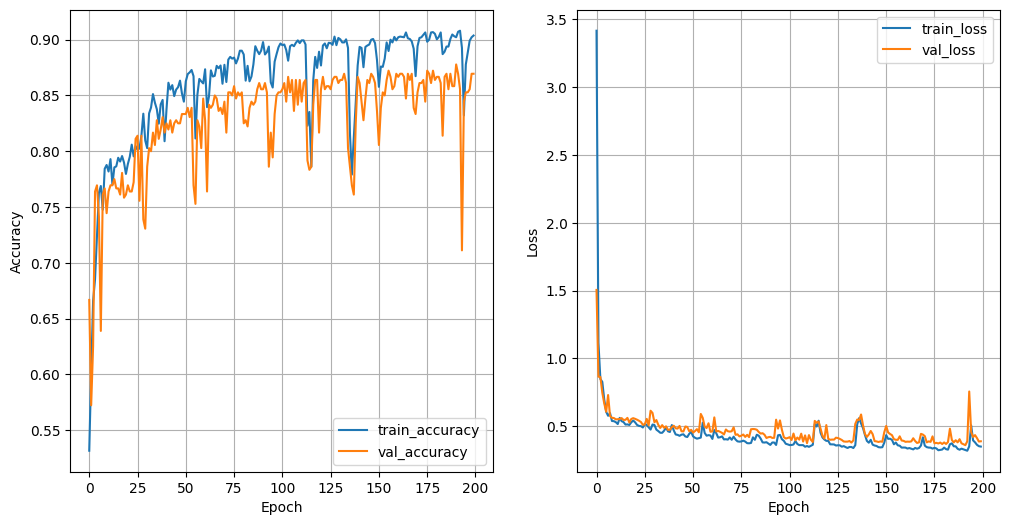

In [8]:
# Mostrar la historia de entrenamiento en diagramas
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Accuracy
    axs[0].plot(history.history['accuracy'], label='train_accuracy')
    axs[0].plot(history.history['val_accuracy'], label='val_accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].grid()
    axs[0].legend()

    # Pérdida
    axs[1].plot(history.history['loss'], label='train_loss')
    axs[1].plot(history.history['val_loss'], label='val_loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].grid()
    axs[1].legend()

    plt.show()

plot_history(history)

## **Parte 5:** Evaluación del modelo

Se evalua el mejor modelo guardado

In [9]:
mejor_modelo = load_model("modelo_generado/mejor_modelo.keras")
resul_eva = mejor_modelo.evaluate(x=X_test_reshaped, y=y_test, verbose=False)

print("Perdida: {:.2f}".format(resul_eva[0]))
print("Accuracy: {:.2%}".format(resul_eva[1]))

Perdida: 0.38
Accuracy: 87.00%


Cálculo de diferentes métricas


Matriz de Confusión:


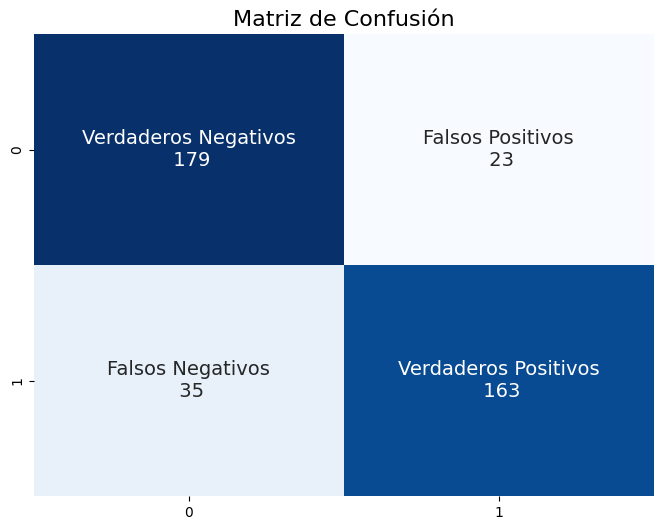

Accuracy:	85.50%
Sensitivity:	82.32%
Specificity:	88.61%
Precision:	87.63%
F1-score:	84.90%


In [11]:
y_pred_prob = mejor_modelo.predict(X_test_reshaped, verbose=False)

# Convertir las probabilidades en clases binarias usando un umbral (por ejemplo, 0.85)
y_pred = (y_pred_prob > 0.8).astype(int)

#Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calcular sensitivity y specificity
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Imprimir resultados
print("\nMatriz de Confusión:")

# Define las etiquetas para los valores en la matriz de confusión
labels = [['Verdaderos Negativos\n', 'Falsos Positivos\n'],
          ['Falsos Negativos\n', 'Verdaderos Positivos\n']]

# Crear una nueva matriz combinando la matriz de confusión y las etiquetas
annot_matrix = [['{} {}'.format(label, value) for label, value in zip(row_labels, row)] for row_labels, row in zip(labels, conf_matrix)]

# Crear un mapa de calor con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=annot_matrix, cmap='Blues', fmt='', cbar=False, annot_kws={'size':14})
plt.title('Matriz de Confusión', fontsize=16)
plt.show()

print("Accuracy:\t{:.2%}".format(accuracy))
print("Sensitivity:\t{:.2%}".format(sensitivity))
print("Specificity:\t{:.2%}".format(specificity))
print("Precision:\t{:.2%}".format(precision))
print("F1-score:\t{:.2%}".format(f1))